In [41]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [42]:
data = pd.read_csv("combined.csv", sep=";")

In [43]:
data.head()

,stock,sector,publication_time,mmt_flags,transaction_id_code,price,volume
0,Sagax_pref,realestate,1612168072,12-------PH---,000184194,35.5,84
1,Sagax_pref,realestate,1612166402,1O-------PH---,000020852,35.4,8
2,Sagax_pref,realestate,1612166402,1O-------PH---,000020851,35.4,28
3,Sagax_pref,realestate,1612166402,1O-------PH---,000020850,35.4,37
4,Sagax_pref,realestate,1612166402,1O-------PH---,000020849,35.4,19


In [44]:
ericsson_data = data[data["stock"]=="Ericsson_A"]
ericsson_data = ericsson_data[["publication_time", "price"]].iloc[::-1]


ericsson_data_ = ericsson_data["price"]
t = round(len(ericsson_data_)*0.8)

train_data = ericsson_data_[:t].to_numpy()
dev_test_data = ericsson_data_[t:]
d = round(len(dev_test_data)/2)
dev_data = dev_test_data[:d].to_numpy()
test_data_ = dev_test_data[d:].to_numpy()
print(len(train_data))
print(len(dev_data))
print(len(test_data_))

14865
1858
1858


In [45]:
datetime.datetime.fromtimestamp(1604304000).strftime('%Y-%m-%d %H:%M:%S')

'2020-11-02 09:00:00'

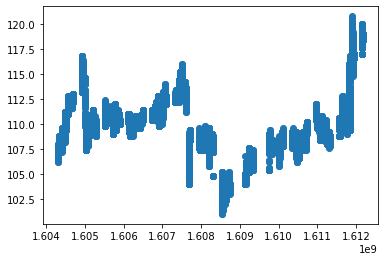

In [46]:
plt.scatter(ericsson_data["publication_time"], ericsson_data["price"])
plt.show()

In [47]:
def getXY(data, input_size, index):
    X = data[index:index+input_size]
    return (X,data[index+input_size])

In [48]:
def createTensorDataset(data, input_size):
    xs = []
    ys = []

    for i in range(len(data)-input_size):
        x,y = getXY(data,input_size, i)
        xs.append(x)
        ys.append(y)

    xs = torch.tensor(xs, dtype=torch.float32)
    ys = torch.tensor(ys, dtype=torch.float32)
    return TensorDataset(xs, ys)

In [71]:
input_size=30
batch_size=1
nbr_epochs=20

In [87]:
class StockModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 30)
        #torch.nn.init.normal_(self.fc1.weight, mean=0, std=1.0)
        self.fc2 = nn.Linear(30, 10)
        #torch.nn.init.normal_(self.fc2.weight, mean=0, std=1.0)
        self.fc3 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.relu(self.fc3(x))

model = StockModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [88]:
def evaluate_model(data, model, loss_fn):
    losses = []
    predictions = []
    with torch.no_grad():
        for x, y in data:
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            predictions.append(pred.item())
        avg_loss = sum(losses)/len(losses)    
    
    return avg_loss, predictions

In [89]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        for x, y in train_data_loader:
            
            y = y.squeeze()
            pred = model(x)
            loss = loss_fn(pred, y)

            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_ = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss))

In [90]:
train_data_loader = DataLoader(createTensorDataset(train_data, input_size), batch_size=batch_size)
dev_data_loader = DataLoader(createTensorDataset(dev_data, input_size), batch_size=batch_size)
test_data = createTensorDataset(test_data_, input_size)

In [91]:
train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)

Epoch 0 	Loss: 2.928 	Loss (val): 1.590
Epoch 1 	Loss: 0.390 	Loss (val): 0.855
Epoch 2 	Loss: 0.347 	Loss (val): 6.869
Epoch 3 	Loss: 0.328 	Loss (val): 7.127
Epoch 4 	Loss: 0.328 	Loss (val): 7.329
Epoch 5 	Loss: 0.328 	Loss (val): 7.463
Epoch 6 	Loss: 0.328 	Loss (val): 7.494
Epoch 7 	Loss: 0.329 	Loss (val): 7.366
Epoch 8 	Loss: 0.330 	Loss (val): 6.997
Epoch 9 	Loss: 0.333 	Loss (val): 6.244
Epoch 10 	Loss: 0.336 	Loss (val): 4.928
Epoch 11 	Loss: 0.341 	Loss (val): 3.280
Epoch 12 	Loss: 0.345 	Loss (val): 2.489
Epoch 13 	Loss: 0.349 	Loss (val): 2.308
Epoch 14 	Loss: 0.351 	Loss (val): 2.264
Epoch 15 	Loss: 0.353 	Loss (val): 2.275
Epoch 16 	Loss: 0.356 	Loss (val): 2.329
Epoch 17 	Loss: 0.361 	Loss (val): 2.421
Epoch 18 	Loss: 0.371 	Loss (val): 2.550
Epoch 19 	Loss: 0.378 	Loss (val): 2.710


In [ ]:
_, preds = evaluate_model(test_data, model, loss_fn)

In [ ]:
plt.plot(list(range(len(test_data_))), test_data_)
plt.plot(list(range(len(preds))), preds)
plt.show()